In [59]:
import collections
import glob
from itertools import chain
import numpy as np
import tensorflow as tf

In [60]:
files = glob.glob('*.txt')

words = []
for f in files:
    file = open(f)
    words.append(file.read())
    file.close()

words = list(chain.from_iterable(words))
words = ''.join(words)[:-1]
sentences = words.split('\n')

In [62]:
vocabulary_size = 40000

def build_dataset(sentences):
    words = ''.join(sentences).split()
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    
    unk_count = 0
    sent_data = []
    for sentence in sentences:
        data = []
        for word in sentence.split():
            if word in dictionary:
                index = dictionary[word]
            else:
                index = 0  # dictionary['UNK']
                unk_count = unk_count + 1
            data.append(index)
        sent_data.append(data)
    
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return sent_data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(sentences)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:2])
# del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 97415], ('the', 667723), ('and', 324431), ('a', 322940), ('of', 289409)]
Sample data [[279, 174, 436, 7048, 46, 3381, 43, 3, 15, 16, 223, 1129, 72, 1707, 1166, 37, 1, 1308, 1603, 2144, 836, 4, 61, 39, 25, 53, 172, 9, 41, 117, 23, 453, 44, 99, 4, 1, 101, 89, 4, 178, 27, 2991, 8, 1, 4180, 2, 7048, 12, 104, 25, 1654, 399, 22, 2, 92, 1501, 364, 73, 304, 33, 61, 57, 9, 117, 23, 453, 1, 104, 70, 142, 64, 453, 44, 6, 3, 53, 9629, 34013, 9799, 9168, 1, 444, 6, 24, 269, 122, 14, 516, 35, 1237, 24, 12, 127, 72, 244, 322, 184, 86, 2, 273, 56, 3794, 4, 3, 17093, 4180, 26, 62, 13182, 721, 5, 29, 1705, 121, 7048, 414, 51, 70, 25, 69, 501, 1, 302, 95, 218, 4, 10, 3890, 7048, 704, 178, 30, 44, 9168, 12, 2991, 70, 25, 556, 134, 9168, 6, 2098, 5, 29, 1, 118, 17, 56, 2521, 15410, 40, 11272, 56, 1314, 129, 7, 13, 30, 9, 96, 78, 5, 386, 37, 1595, 7, 122, 34, 519, 8], [10, 6, 34, 464, 4, 134, 1, 2219, 4, 205, 105, 25, 1, 168, 3854, 2, 347, 39, 12, 64, 163, 276, 149, 129, 3,

In [65]:
skip_window = 3
instances = 0
for sentence  in data:
    instances += len(sentence)-2*skip_window
print(instances)    

11408957


In [66]:
context = np.zeros((instances,skip_window*2),dtype=np.int32)
labels = np.zeros((instances,1),dtype=np.int32)
doc = np.zeros((instances,1),dtype=np.int32)

k = 0
for doc_id, sentence  in enumerate(data):
    for i in range(skip_window, len(sentence)-skip_window):
        buffer = sentence[i-skip_window:i+skip_window+1]
        del buffer[skip_window]
        labels[k] = sentence[i]
        context[k] = buffer
        doc[k] = doc_id
        k += 1
        
shuffle_idx = np.random.permutation(k)
labels = labels[shuffle_idx]
doc = doc[shuffle_idx]
context = context[shuffle_idx]

In [116]:
batch_size = 256
context_window = 2*skip_window
embedding_size = 50 # Dimension of the embedding vector.
softmax_width = embedding_size # +embedding_size2+embedding_size3
num_sampled = 100 # Number of negative examples to sample.
sum_ids = np.repeat(np.arange(batch_size),context_window)

len_docs = len(data)

graph = tf.Graph()

with graph.as_default(): # , tf.device('/cpu:0')
    # Input data.
    train_word_dataset = tf.placeholder(tf.int32, shape=[batch_size*context_window])
    train_doc_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

    segment_ids = tf.constant(sum_ids, dtype=tf.int32)

    word_embeddings = tf.Variable(tf.random_uniform([vocabulary_size,embedding_size],-1.0,1.0))
    doc_embeddings = tf.Variable(tf.random_uniform([len_docs,embedding_size],-1.0,1.0))

    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, softmax_width],
                             stddev=1.0 / np.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    embed_words = tf.segment_sum(tf.nn.embedding_lookup(word_embeddings, train_word_dataset),segment_ids)
    embed_docs = tf.nn.embedding_lookup(doc_embeddings, train_doc_dataset)
    embed = embed_words+embed_docs#+embed_hash+embed_users

    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.nce_loss(softmax_weights, softmax_biases, embed,
                                   train_labels, num_sampled, vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(0.5).minimize(loss)
        
    norm = tf.sqrt(tf.reduce_sum(tf.square(doc_embeddings), 1, keep_dims=True))
    normalized_doc_embeddings = doc_embeddings / norm

In [117]:
############################
# Chunk the data to be passed into the tensorflow Model
###########################
data_idx = 0
def generate_batch(batch_size):
    global data_idx

    if data_idx+batch_size<len_docs:
        batch_labels = labels[data_idx:data_idx+batch_size]
        batch_doc_data = doc[data_idx:data_idx+batch_size]
        batch_word_data = context[data_idx:data_idx+batch_size]
        data_idx += batch_size
    else:
        overlay = batch_size - (len_docs-data_idx)
        batch_labels = np.vstack([labels[data_idx:len_docs],labels[:overlay]])
        batch_doc_data = np.vstack([doc[data_idx:len_docs],doc[:overlay]])
        batch_word_data = np.vstack([context[data_idx:len_docs],context[:overlay]])
        data_idx = overlay
    batch_word_data = np.reshape(batch_word_data,(-1,1))

    return batch_labels, batch_word_data, batch_doc_data

In [118]:
num_steps = 1000001
step_delta = int(num_steps/20)

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_labels, batch_word_data, batch_doc_data\
        = generate_batch(batch_size)
        feed_dict = {train_word_dataset : np.squeeze(batch_word_data),
                     train_doc_dataset : np.squeeze(batch_doc_data),
                     train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % step_delta == 0:
            if step > 0:
                average_loss = average_loss / step_delta
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0

    # Get the weights to save for later
#     final_doc_embeddings = normalized_doc_embeddings.eval()
    final_word_embeddings = word_embeddings.eval()
    final_word_embeddings_out = softmax_weights.eval()
    final_doc_embeddings = normalized_doc_embeddings.eval()

Initialized
Average loss at step 0: 426.157104
Average loss at step 50000: 7.854996
Average loss at step 100000: 0.641150
Average loss at step 150000: 0.603961
Average loss at step 200000: 0.594481
Average loss at step 250000: 0.589963
Average loss at step 300000: 0.586765
Average loss at step 350000: 0.584712
Average loss at step 400000: 0.583086
Average loss at step 450000: 0.582070
Average loss at step 500000: 0.581260
Average loss at step 550000: 0.580287
Average loss at step 600000: 0.579365
Average loss at step 650000: 0.579081
Average loss at step 700000: 0.578365
Average loss at step 750000: 0.578061
Average loss at step 800000: 0.577644
Average loss at step 850000: 0.577144
Average loss at step 900000: 0.576824
Average loss at step 950000: 0.576325
Average loss at step 1000000: 0.576282


In [119]:
rand_doc = np.random.randint(len_docs)
dist = final_doc_embeddings.dot(final_doc_embeddings[rand_doc][:,None])
closest_doc = np.argsort(dist,axis=0)[-4:][::-1]

for idx in closest_doc:
    print(dist[idx][0][0])

1.0
0.539897
0.535443
0.523045


In [120]:
sentences[rand_doc]

'i love this movie beautifully funny and utterly believable characters each scene richer and more wonderful than the last every aspect of this movie is filled with wit and humour and love and depth a complex and engrossing story too this movie is filled with love humour and intelligence totally great '

In [121]:
sentences[closest_doc[1][0]]

'for many the hit series was ten years of pitch black humour loaded with affectionate parodies of classic films and a hilarious assortment of over a hundred characters with instantly recognisable catchphrases few shows have survived transition from radio to tv to stage show to film but the league of gentlemen have achieved it with suitable aplomb the talented writer performers had initially envisioned a monty python style medieval adventure but as soon as writing began they soon realised that the characters they have lived with had become very real and deserved better with that the royston vasey folk realise their very existence is under threat as the writers decide to disregard the fictitious town and work on a th century romp instead with the exception of michael sheen playing much unseen league member jeremy dyson the league play pretty unlikeable caricatures of their real life personae as well as the familiar faces of tubbs i made a little brown fishy nightmare inducing sexual pred

In [122]:
sentences[closest_doc[2][0]]

'my wife and i watched this marvelous movie this evening because we will watch russian dolls tomorrow and the first is important to see before the second we both loved the spaniah apartment and will enjoy following some of the characters through the early years of their lives now in st pertersburg russia we both identified slightly with the rough framework of the story because we were students florence italy for us so the script was not completely foreign to our early lives our living was considerably different but as with this movie anytime you throw together young people passing through the same life hoops as any developed world people they will experience much the same life situations the collection of people and the personal difficulties that they faced were universals and therein lies the beauty of this film and probably its sequence that i will see tomorrow as i wrote the characters as well as these situations are familiar to all of us and therefore we can enjoy living their live

In [123]:
sentences[closest_doc[3][0]]

'despite myself i really kinda like this movie pauley shore is invariably laugh out loud funny and here is no exception he is just excellent at playing the weirdo with a heart of gold his performance in this although nothing out of the ordinary for him is so good it seems to lift other cast members performances perhaps this is because he s the kind of guy it s easy to bounce off of the clich s about country life in this movie are hilarious and the way shore s city boy crawl is so at odds with the way of life is funny too but it s not only he who s a fish out of water comedy also comes from the fact that to any ordinary person or people crawl is a freakish nightmare of a person that s why this movie works in such a great way we love crawl he s a breath of fresh air but we can also sympathise with the warners he is one hell of a culture shock although this movie is classic pauley shore so there s no great brain power needed to enjoy the movie enjoy it you do and there s even a never judg

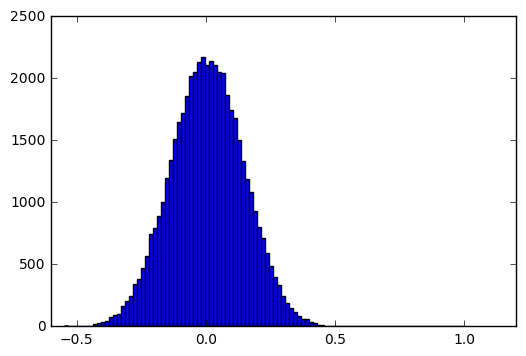

In [124]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(dist,100)
plt.show()

## Gensim Model

In [139]:
import gensim
from gensim.models import Doc2Vec
from multiprocessing import cpu_count

cpus = cpu_count()

In [148]:
def read_corpus():
    for i,sentence in enumerate(words.split('\n')):
        yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(sentence), [i])

train_corpus = list(read_corpus())

In [152]:
model = Doc2Vec(dm=1, dm_concat=0, size=embedding_size, window=skip_window, 
                negative=num_sampled,hs=0, min_count=5, workers=cpus, iter=10)
model.build_vocab(train_corpus)

In [ ]:
%%time
model.train(train_corpus)